# Bandit Sequence Design

This notebook is for the second round design. The current design only makes use of the first round results. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
#import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading First Round Results (new data)

In [2]:
# Data contains both the first round result and baseline data
#
# columns: 
# RBS: 20-length RBS seq
# RBS6: 6-length RBS seq, which the [7:13] positions
# variable: for first round results, denote which replication is the seq. 
# label: normalised label (zero mean and unit variance)

Path = '../../data/firstRound_4h+Baseline.csv'

df = pd.read_csv(Path)
df.head()

,Unnamed: 0,AVERAGE,Group,RBS,RBS6,STD,label,variable
0,0,2.592357,bps,TTTAAGAAGGAGATATACAT,AGGAGA,0.717515,3.194925,Rep1
1,1,1.604161,bps,CTTAAGAAGGAGATATACAT,AGGAGA,0.284382,1.844257,Rep1
2,2,0.662662,bps,GTTAAGAAGGAGATATACAT,AGGAGA,0.017069,0.674610,Rep1
3,3,1.678999,bps,ATTAAGAAGGAGATATACAT,AGGAGA,0.500712,1.986839,Rep1
4,4,1.671743,bps,TCTAAGAAGGAGATATACAT,AGGAGA,0.624388,1.830061,Rep1


(562, 8)

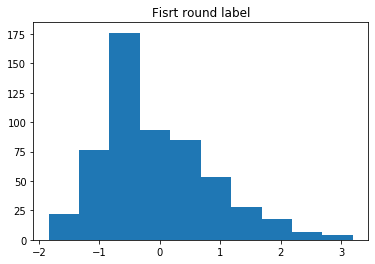

In [3]:
# extract first round result
df_FRR = df[df['Group'] != 'Baseline dataset']
plt.hist(df_FRR['label'])
plt.title('Fisrt round label')
df_FRR.shape

In [4]:
data = np.asarray(df_FRR[['RBS', 'label']])
#data = np.asarray(df[['RBS', 'label']])
data.shape

(562, 2)

In [5]:
data6 = np.asarray(df_FRR[['RBS6', 'label']])
#data6 = np.asarray(df[['RBS6', 'label']])
data6.shape

(562, 2)

Text(0.5, 1.0, 'Normalised GFPOD Histogram')

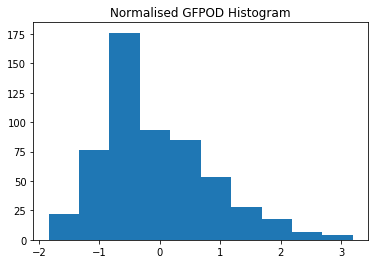

In [6]:
plt.hist(data[:,1])
plt.title('Normalised GFPOD Histogram')

## Construct feature spaces

We fix the part other the designing 6-base RBS, the 20-based RBS would be: 'TTTAAGA' + 6-base design + 'TATACAT'. The 6-base design has totally 4^6 = 4096 combinations. 

In [7]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in product(char_sets, repeat= design_len):
    combos_6.append(''.join(combo))
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len

In [8]:
todesign_data = np.asarray(list(zip(combos, labels))) # 20-base
todesign6_data = np.asarray(list(zip(combos_6, labels))) # 6-base

## Setting

Since the sequences in provided data have the pattern that the core area is different from each other, and other areas are similar. So the kernel for Gaussain Process we are using is the sum of kernels, for core areas we use spectrum kernel with string as input directly, and for other areas we use onehot encoding and dot product kernel for simplicity. 

In [9]:
embedding = 'label'
# sum_spectrum_kernel_pw: spectrum kernels for [:7], [7:13], [13:] respectively

spec_kernel = Spectrum_Kernel()
sum_spec_kernel = Sum_Spectrum_Kernel()

kernel = sum_spec_kernel
string_kernel_flag = True

## Recommendations with GPUCB

[3503 1782 2543  763 1983 1778 2043  623 1995  635 2806 2024 2249  562
 1515  506 2523 2802 3506 1586 2763  879  607  943 2539 2335  479 3487
  502 2991 1951 3519 1970  498 2555 2610 2927 2251 2271 1311  639 2287
 2847  287 2863 1787 2811  475 2283 2015  495 2267 2079 3055  507 3039
  491 3051 2011 3231 1903 3035 1967 2027 2031]


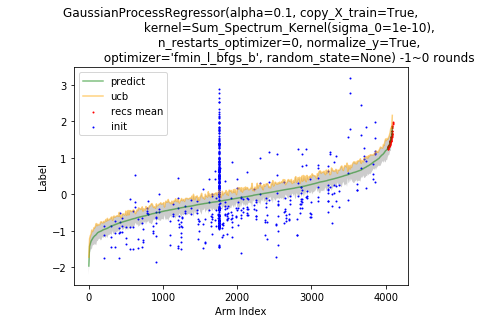

In [10]:
num_rounds = 1 
num_exper = 1
num_rec = 65
alpha = 0.1

my_env = Rewards_env(data, embedding)
new_env = Rewards_env(todesign_data, embedding)

agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
          model = GaussianProcessRegressor(kernel = kernel, alpha = alpha, normalize_y =True))
rec_arms = agent.play(label_avaiable = False)

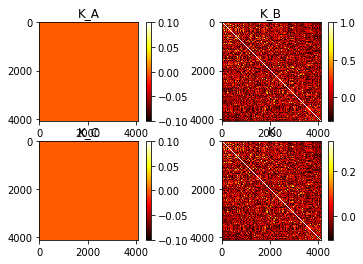

In [11]:
sorted_idx = np.asarray(sorted(range(len(agent.mu)), key = lambda k : (agent.mu)[k]))

kernel_matrix = kernel.__call__(np.asarray(combos)[sorted_idx], np.asarray(combos)[sorted_idx], plot_flag = True)

### Convert to RBS seq

In [12]:
bandit20_recs = todesign_data[np.asarray(rec_arms[-60:]),0]

In [13]:
bandit20_recs

array(['TTTAAGAGCTTACTATACAT', 'TTTAAGAGTTTCTTATACAT',
       'TTTAAGAACGCTTTATACAT', 'TTTAAGAGTTACTTATACAT',
       'TTTAAGAACGTCTTATACAT', 'TTTAAGACCTTGCTATACAT',
       'TTTAAGAGTTCCATATACAT', 'TTTAAGACATACGTATACAT',
       'TTTAAGAACATACTATACAT', 'TTTAAGAGGTCCTTATACAT',
       'TTTAAGAAGTTCCTATACAT', 'TTTAAGACGTGCTTATACAT',
       'TTTAAGACCTTACTATACAT', 'TTTAAGATGCTACTATACAT',
       'TTTAAGAGCATACTATACAT', 'TTTAAGACCTACTTATACAT',
       'TTTAAGAATGCTTTATACAT', 'TTTAAGAACGGTTTATACAT',
       'TTTAAGAATCCTTTATACAT', 'TTTAAGACGTCCTTATACAT',
       'TTTAAGACGAGTTTATACAT', 'TTTAAGAAGTGTTTATACAT',
       'TTTAAGATGCGTTTATACAT', 'TTTAAGAAGTTGCTATACAT',
       'TTTAAGACTCCTTTATACAT', 'TTTAAGAGTCGTTTATACAT',
       'TTTAAGATGCTTTTATACAT', 'TTTAAGAGTCTACTATACAT',
       'TTTAAGAAGTTACTATACAT', 'TTTAAGACGTTCTTATACAT',
       'TTTAAGACCATACTATACAT', 'TTTAAGACTGCTTTATACAT',
       'TTTAAGACATACTTATACAT', 'TTTAAGACATGTTTATACAT',
       'TTTAAGAGGAGTTTATACAT', 'TTTAAGAACGTTTTATACAT',
       'TT

### Detect Repeated Recs

In [14]:
first_round_seq = pd.read_csv('../../data/first_round_seq.csv')

In [15]:
first_round_seq

,RBS,Group,RBS6
0,TTTAAGAAGGAGATATACAT,bps,AGGAGA
1,CTTAAGAAGGAGATATACAT,bps,AGGAGA
2,GTTAAGAAGGAGATATACAT,bps,AGGAGA
3,ATTAAGAAGGAGATATACAT,bps,AGGAGA
4,TCTAAGAAGGAGATATACAT,bps,AGGAGA
...,...,...,...
176,TTTAAGAACCCCCTATACAT,bandit,ACCCCC
177,TTTAAGATCCCCCTATACAT,bandit,TCCCCC
178,TTTAAGAGGATAATATACAT,bandit,GGATAA
179,TTTAAGACCCCCCTATACAT,bandit,CCCCCC


In [16]:
def common_member(a, b): 
    assert len(a[0]) == len(b[0]) 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

In [17]:
bandit_drop = common_member(np.asarray(first_round_seq['RBS']), bandit20_recs)
bandit_drop

'no common elements'

In [18]:
if type(bandit_drop) is set:
    bandit20_recs = list(bandit20_recs)
    for i in bandit_drop:
        print(i)
        bandit20_recs.remove(i)
        
    bandit20_recs.extend(todesign_data[np.asarray(rec_arms[60: 60 + len(bandit_drop)]),0])
    assert common_member(np.asarray(first_round_seq['RBS']), bandit20_recs) == 'no common elements'
    assert len(bandit20_recs) == 60

### Write into csv file

In [19]:
recs = pd.DataFrame(bandit20_recs, columns = ['bandit'])
recs.index += 1
recs.to_csv('../../data/bandit_recs_second_round.csv')

#### Sanity test of idx consistency

In [20]:
label_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]
label_dict = {'0': 'A',
              '1': 'C',
              '2': 'G',
              '3': 'T'}

rbs_seqs = []

for seq in label_seqs:
    rbs_seq = []
    for i in range(int(len(seq))):
        start = i 
        end = start + 1
        s = seq[start:end]
        rbs_seq.append(label_dict[s])
    rbs_seq = ''.join(rbs_seq)
    rbs_seqs.append(rbs_seq)

for i in range(len(rec_arms)):
    assert rbs_seqs[i] == todesign_data[rec_arms[i], 0] 
    
print('Recommned index is consistent of the todesign_data index.')

Recommned index is consistent of the todesign_data index.


### Plot kernel matrix 

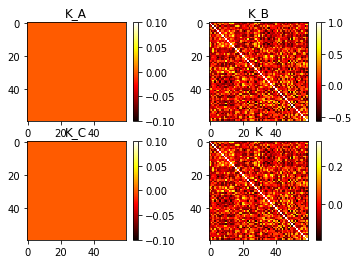

In [21]:
# use 6-base seuqence for kernel matrix

recs_seq= np.asarray(recs['bandit'])

kernel_matrix = kernel.__call__(recs_seq, recs_seq, plot_flag = True)

In [22]:
kernel_matrix 

array([[ 0.33333333, -0.02616683, -0.03334642, ..., -0.04026205,
        -0.00420623, -0.05565158],
       [-0.02616683,  0.33333333, -0.11281121, ..., -0.02404207,
         0.15793487,  0.18861335],
       [-0.03334642, -0.11281121,  0.33333333, ...,  0.00145686,
        -0.13801267, -0.00792108],
       ...,
       [-0.04026205, -0.02404207,  0.00145686, ...,  0.33333333,
         0.11185081,  0.14089546],
       [-0.00420623,  0.15793487, -0.13801267, ...,  0.11185081,
         0.33333333,  0.11874335],
       [-0.05565158,  0.18861335, -0.00792108, ...,  0.14089546,
         0.11874335,  0.33333333]])

### Save into file

In [23]:
import pickle

with open('second_round_rec.pickle', 'wb') as handle:
    pickle.dump(agent, handle, protocol=pickle.HIGHEST_PROTOCOL)